In [140]:
import sys
sys.path.append('../')

In [141]:
%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params:

In [142]:
aggregate_by_state = False
evaluation_criteria = 'predict current day' #Out of ['hold out counties','predict current day']

## Basic Data Visualization

In [167]:
# Just something to quickly summarize the number of cases and distributions each day

In [143]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(dir_mod = '../')
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)

In [144]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
1595


(array([72., 33., 28., 25., 21., 15., 12.,  6., 10.,  5.,  4., 10.,  3.,
         3.,  4.,  3.,  7.,  2.,  1.,  0.,  1.,  2.,  0.,  1.,  3.,  1.,
         1.,  1.,  2.,  0.,  1.,  0.,  1.,  3.,  0.,  0.,  0.,  1.,  1.,
         1.,  0.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 21.  ,  30.76,  40.52,  50.28,  60.04,  69.8 ,  79.56,  89.32,
         99.08, 108.84, 118.6 , 128.36, 138.12, 147.88, 157.64, 167.4 ,
        177.16, 186.92, 196.68, 206.44, 216.2 , 225.96, 235.72, 245.48,
        255.24, 265.  , 274.76, 284.52, 294.28, 304.04, 313.8 , 323.56,
        333.32, 343.08, 352.84, 362.6 , 372.36, 382.12, 391.88, 401.64,
        411.4 , 421.16, 430.92, 440.68, 450.44, 460.2 , 469.96, 479.72,
  

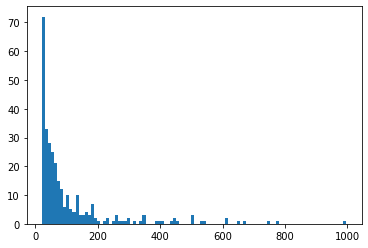

In [145]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [146]:
sum(max_cases)

82163

In [147]:
print(sum([v > 50 for v in max_cases]))


177


In [148]:
np.quantile(max_cases,.5)

3.0

Number of counties with non-zero deaths
267


(array([106.,   9.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2. ,  14.1,  26.2,  38.3,  50.4,  62.5,  74.6,  86.7,  98.8,
        110.9, 123. , 135.1, 147.2, 159.3, 171.4, 183.5, 195.6, 207.7,
        219.8, 231.9, 244. , 256.1, 268.2, 280.3, 292.4, 304.5, 316.6,
        328.7, 340.8, 352.9, 365. ]),
 <a list of 30 Patch objects>)

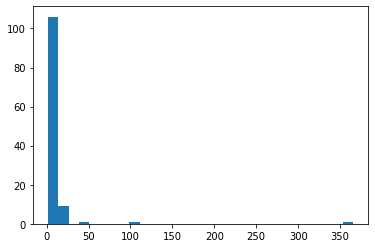

In [149]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

print('Number of counties with non-zero deaths')
print(sum([v >0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 1],bins=30)

In [168]:
sum(max_deaths)

1220

In [169]:
max(max_deaths)

365

In [170]:
np.quantile(max_deaths,.5)

0.0

### Clean data

In [153]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
df =  df[df['max_cases'] > 0]


In [154]:
# Ignore, currently deprecated
if evaluation_criteria == 'hold out counties':
    print('currently deprecated')
    raise NotImplementedError
    # Randomly select counties for train/test split

    # Shuffle data
    shuffled_df = df_with_cases.sample(frac=1)
    # Break into train test (random k-fold cross val on the training set is done to pick hyperparams)
    train_ratio, val_ratio, test_ratio = .75,0,.25

    train_df = shuffled_df[0:int(train_ratio*len(shuffled_df))]
    test_df = shuffled_df[int(train_ratio*len(shuffled_df))+int(val_ratio*len(shuffled_df)):]
elif evaluation_criteria == 'predict current day':
    # Train df is all previous days
    # Test df is all days including current day
    previous_deaths = [d[:-1] for d in copy.deepcopy(df['deaths'])]
    previous_cases = [c[:-1] for c in copy.deepcopy(df['cases'])]
    train_df = copy.deepcopy(df)
    train_df['deaths'] = previous_deaths
    train_df['cases'] = previous_cases
    test_df = df
else:
    print('Unknown evaluation criteria')
    raise ValueError




## Predict data from model:

In [155]:
# Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# to a new column for test_df 
fit_and_predict(train_df, test_df, method='exponential')
fit_and_predict(train_df, test_df,'shared_exponential')
fit_and_predict(train_df, test_df, method='exponential',target_day = np.array([1,2]))

# Finds the names of all the methods
method_keys = [c for c in test_df if 'predicted' in c]

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [156]:
# Computes the mse in log space and non-log space for all columns

In [157]:
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
number_of_deaths_threshold = 10

In [158]:
# Log scaled
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in test_df[key][outcome > number_of_deaths_threshold]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[outcome > number_of_deaths_threshold]),preds))

Log scale MSE for predicted_deaths_exponential_1
0.026672534626003944
Log scale MSE for predicted_deaths_shared_exponential_1
0.024685504494858033
Log scale MSE for predicted_deaths_exponential_2
0.20938301222090638


In [159]:
# No log scale
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in test_df[key][outcome > number_of_deaths_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > number_of_deaths_threshold],preds))

Raw MSE for predicted_deaths_exponential_1
360.7087849157962
Raw MSE for predicted_deaths_shared_exponential_1
29.60611898985021
Raw MSE for predicted_deaths_exponential_2
6192.528074939427


### Plot residuals

In [160]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

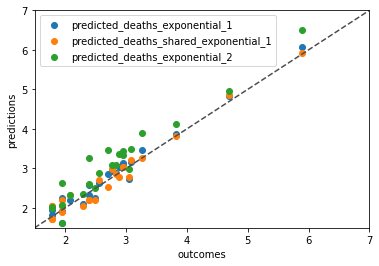

In [161]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in test_df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)
    
plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

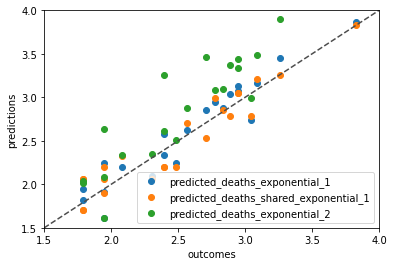

In [162]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in test_df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

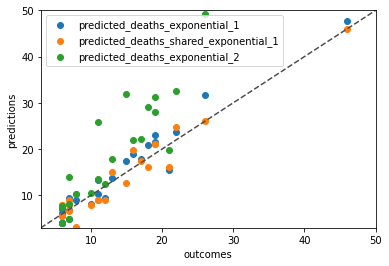

In [163]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [3, 50]
outcome = np.array([df['deaths'].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in test_df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=key)

plt.xlabel('outcomes')
plt.ylabel('predictions')
plt.xlim(bounds)
plt.ylim(bounds)
plt.legend()

plt.plot(bounds, bounds, ls="--", c=".3")

### Graph Visualizations

In [ ]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [164]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = 'deaths'
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
    plt.plot(row[gold_key][start_point:], label=gold_key)

    
    
    for key in method_keys:
        preds = row[key]

        plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
    plt.legend()
    plt.show()
    

New York in NY


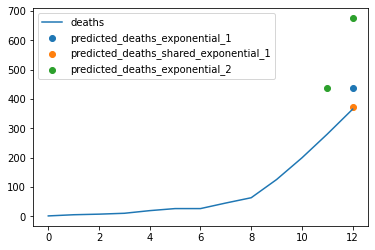

King in WA


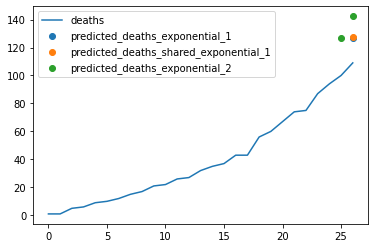

Orleans in LA


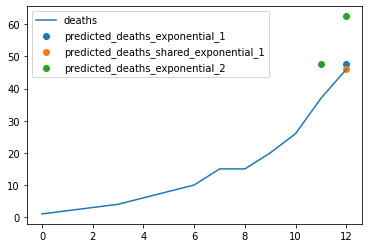

Suffolk in NY


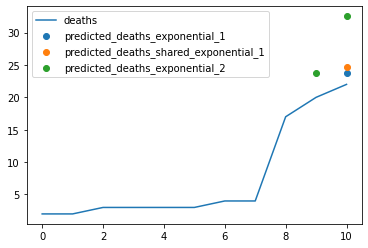

Snohomish in WA


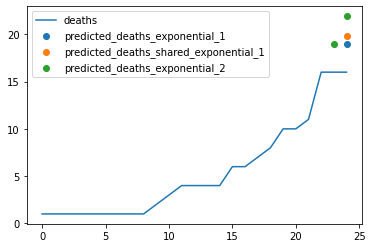

Santa Clara in CA


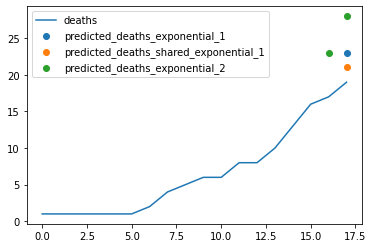

Bergen in NJ


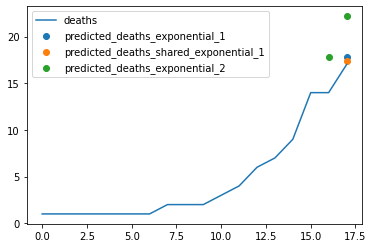

Wayne in MI


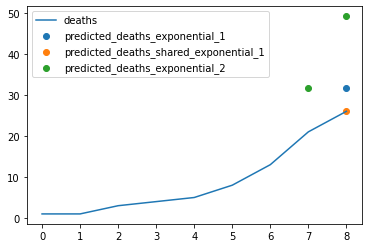

Cook in IL


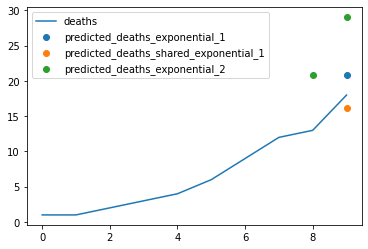

Los Angeles in CA


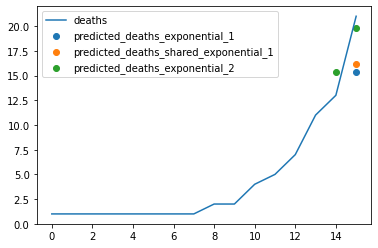

Fairfield in CT


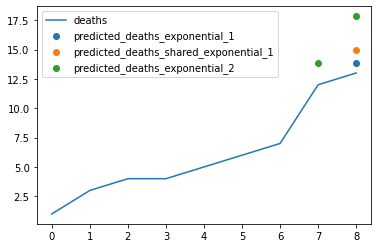

Essex in NJ


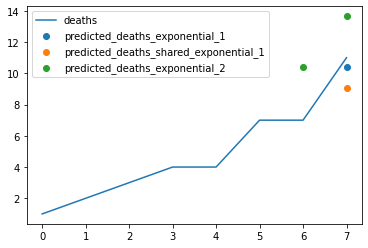

Nassau in NY


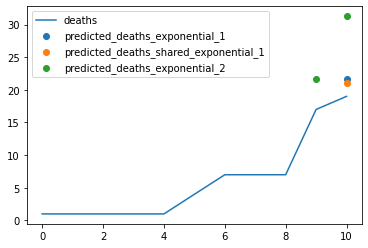

Jefferson in LA


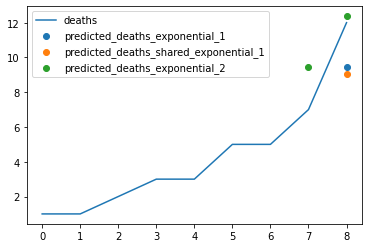

Oakland in MI


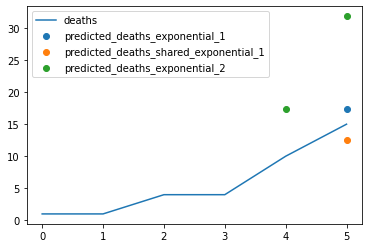

Macomb in MI


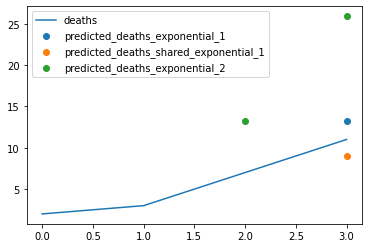

In [165]:
for i in range(len(test_df)):
    row = test_df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)